### Median Filter using Dask framework

In [1]:
# Used Libraries
import numpy as np
from dask_image import imread
from dask import array as darr
import matplotlib.pyplot as plt
%matplotlib inline

# Defined Constants
IMG = "lena_noisy.jpg"
X_BLOCKSIZE = 8
Y_BLOCKSIZE = 8

#### Loading the noisy image

dask.array<from-value, shape=(1, 128, 128, 3), dtype=uint8, chunksize=(1, 128, 128, 3), chunktype=numpy.ndarray>

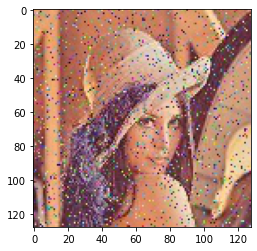

In [2]:
noisy = imread.imread(IMG)
plt.imshow(noisy[0])
noisy

As we can see, the image is already too small for Dask to import it on more than one chunk. Although generally this isn't a problem as we're dealing with a little `(128,128)` image, it defeats the purpose of the lab we're trying to implement. What we're going to do so is to *re-split* it on more chunks so that Dask will be able to run parallel processes over it.

To split the image, we chose to do it in a 2D way so that we have a chunk dimension of `(8,8,3)` (3 being the number of channels). Even if we chose a number that doesn't belong to the dividors of one of our image's dimensions, we won't have any kind of problem cause Dask will handle that by tolerating the rest of the area being in seperate chunks in a load-balancing way (instead of a chunk of 7x7, maybe create 3 chunks: 2 of 3x3 shape and a 1 pixel chunk).

In [3]:
chunked = noisy[0].rechunk(chunks=(X_BLOCKSIZE, Y_BLOCKSIZE, 3))
chunked

,Array,Chunk
Bytes,49.15 kB,192 B
Shape,"(128, 128, 3)","(8, 8, 3)"
Count,515 Tasks,256 Chunks
Type,uint8,numpy.ndarray


To apply our median filter, we can either choose to not treat the borders of our image, or just add a padding (reflective or constant one) around the image to be able to filter the original borders as well. For this lab we're going with the first option by just ignoring the outer borders of our image and only work on the inner matrix.

Now we know that the median filter we want to apply needs a visibility of the neighboring of each of the cells it's working on. This kind of communication would throttle down the parallelization process of the whole filtering pipeline. To transform this into an embarassingly parallel problem, we chose to implement the **Ghost Cells** approach by picking the boundaries of each of our partition into account for each parallel filtering operation.

In Dask, this is done by the `dask.array.overlap.overlap` function by specifying the depth/radius of each neighboring to add on the boundaries of each of our provided chunks.

In [4]:
extended = darr.overlap.overlap(chunked, depth={0:1,1:1}, boundary='reflect')
extended

,Array,Chunk
Bytes,76.80 kB,300 B
Shape,"(160, 160, 3)","(10, 10, 3)"
Count,4479 Tasks,256 Chunks
Type,uint8,numpy.ndarray


Now, we need to write a normal median filter function to be applied over all chunks of our original image. As we already coded one similar function on the *Spark* exercise of this same Lab, we decided to go with the `scipy` library predefined median filter function. We also provided a matrix as a footprint for this median filter being `np.ones((3,3,1))`. This would mean that the neighbouring the filter is applied on each time is *only* on the length and width dimensions, so it being *channel-wise* (each channel applies a seperate median filter).

In [8]:
from scipy.ndimage.filters import median_filter
def partial_median(block):
    return median_filter(block, footprint=np.ones((3,3,1)))

And of course, to apply this filter function on all elements of our parallel array, we use the `dask.array.map_blocks` function. No need to provide the `chunks` parameter as we don't change the input dimensions.

In [9]:
filtered = extended.map_blocks(partial_median)

Finally, we need to get rid of the excess ghost cells we created before applying the median filter. This is done by the `dask.array.overlap.trim_internal` function also by specifying the neighbouring depth already used for the extension previously done.

,Array,Chunk
Bytes,49.15 kB,192 B
Shape,"(128, 128, 3)","(8, 8, 3)"
Count,5247 Tasks,256 Chunks
Type,uint8,numpy.ndarray


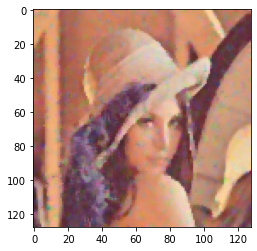

In [10]:
result = darr.overlap.trim_internal(filtered, {0:1,1:1})
plt.imshow(result)
result